In [1]:
from Helper import * 
data_link = './Data/'

In [2]:
df = pd.read_csv(data_link+'train_FD003.txt',sep=" ",header=None)
dft = pd.read_csv(data_link+'test_FD003.txt',sep=" ",header=None)
rul_link = "RUL_FD003.txt"

# Dropping columns 26 and 27
df.dropna(axis=1,inplace=True)
dft.dropna(axis=1,inplace=True)

columns = ['unit_number','time_in_cycles','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11',
'sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21','sensor22','sensor23','sensor24', ]

df.columns,dft.columns = columns,columns

# Add RUL Coloumn to the dataset
df = prepare_train_data(df)
df = df.loc[~(df.unit_number==10)]
df['Acheck'] = (df['time_in_cycles']>200).values.astype(int)
df['Bcheck'] = (df['time_in_cycles']>300).values.astype(int)
unit_number = pd.DataFrame(df["unit_number"])

### Drop useless columns 
const_cor_cols = ['sensor3','sensor4','sensor8','sensor19','sensor21','sensor22']
cor_col = ['sensor15','sensor16','sensor17'] 
# cor_col = ['sensor16']

df.drop(columns=const_cor_cols,inplace=True)
df.drop(columns=cor_col,inplace=True)
# add A check
try:
    train_df = df.drop(columns='unit_number',axis=1)
except KeyError:
    pass


dft.drop(columns=const_cor_cols,inplace=True)
dft.drop(columns=cor_col,inplace=True)
dft['Acheck'] = (dft['time_in_cycles']>200).values.astype(int)
dft['Bcheck'] = (dft['time_in_cycles']>300).values.astype(int)

# find the time cycle which gives the max cycles
test_max = dft.groupby('unit_number')['time_in_cycles'].max().reset_index()
test_max.columns = ['unit_number','max']
dft = dft.merge(test_max, on=['unit_number'], how='left')
test = dft[dft['time_in_cycles'] == dft['max']].reset_index()
test.drop(columns=['index','max','unit_number'],inplace = True)
test_df = test.to_numpy()

# Check is train and test data columns match
if np.array_equal(test.columns.values,train_df.drop(columns=['RUL']).columns.values):
    print("Columns Match")
else:
    print("Columns DON'T Match")

print(f"Test Dataset shape: {test_df.shape}")

Columns Match
Test Dataset shape: (100, 18)


# Forest Model

In [3]:
model_1 = train_models(train_df)
y_pred = model_1.predict(test_df)

# Get y true
RUL = pd.read_csv(data_link+rul_link,sep=" ",header=None)
y_true = RUL[0].to_numpy()
RF_individual_scorelst = score_func(y_true, y_pred)

 compatitive score 77221.8
 mean absolute error 31.85
 root mean squared error 42.76166507515815
 R2 score -0.07


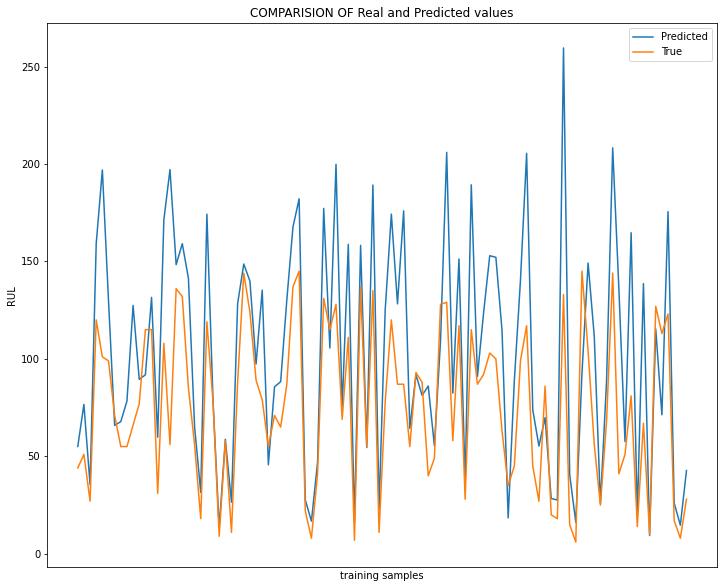

In [4]:
plot_result(y_true,y_pred)

# LSTM

In [5]:
train_df_lstm = pd.concat([unit_number, train_df], axis=1)
model, history, lstm_test_df, seq_array, label_array, sequence_length, sequence_cols = train_models([train_df_lstm, dft, RUL.copy()], "LSTM")
lstm_test_evaluation_graphs(model, history, seq_array, label_array)

train_df:-     unit_number  time_in_cycles   sensor1   sensor2   sensor5   sensor6  \
0            1               1  0.470930  0.769231  0.355972  0.370523   
1            1               2  0.546512  0.230769  0.388759  0.399100   

   sensor7  sensor9  sensor10  sensor11  ...  sensor18  sensor20  sensor23  \
0  0.30858      1.0  0.208812  0.623529  ...  0.647755  0.272727  0.559524   
1  0.30936      1.0  0.236590  0.647059  ...  0.685659  0.363636  0.488095   

   sensor24  RUL  Acheck  Bcheck  label1  label2  cycle_norm  
0  0.446331  258     0.0     0.0       0       0    0.000000  
1  0.534836  257     0.0     0.0       0       0    0.001908  

[2 rows x 23 columns]


test_df:-     unit_number  time_in_cycles   sensor1   sensor2   sensor5   sensor6  \
0            1               1  0.411765  0.166667  0.330128  0.400713   
1            1               2  0.547059  0.333333  0.355769  0.470392   

    sensor7  sensor9  sensor10  sensor11  ...  sensor18  sensor20  sensor23  \
0  

KeyboardInterrupt: 

In [ ]:
MAE, R2, y_pred = lstm_valid_evaluation(lstm_test_df, model, sequence_length, sequence_cols)
# mae, rmse, r2
LSTM_individual_scorelst = [round(MAE,2), 0, round(R2,2)*100]